In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft, rfft, rfftfreq

# ==============================
# USER SETTINGS
# ==============================
FILE_PATH = "./TestCode/PeakFitting/GaN_68K_200ms_Start.csv"  # <-- change this
X_COLUMN = "Energy_eV"                 # or "Wavelength_nm"
Y_COLUMN = "Counts"
cutoff = 2.6
PEAK_SHAPE = "pvoigt"  # "gaussian", "lorentzian", or "pvoigt"
# ==============================
# LOADING AND PRE-PROCESSING
# ==============================
df_raw = pd.read_csv(FILE_PATH)
df = df_raw[df_raw[X_COLUMN] >= cutoff]

if X_COLUMN not in df.columns or Y_COLUMN not in df.columns:
    raise ValueError(f"Columns {X_COLUMN!r} and {Y_COLUMN!r} must exist in the file.")

x = df[X_COLUMN].to_numpy(dtype=float)
y_raw = df[Y_COLUMN].to_numpy(dtype=float)

# Sort by x just in case
order = np.argsort(x)
x = x[order]
y_raw = y_raw[order]

# Simple baseline shift + normalization for fitting stability
y = y_raw - np.min(y_raw)
if np.max(y) > 0:
    y = y / np.max(y)

import numpy as np

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def lorentzian(x, A, mu, gamma):
    # gamma == HWHM
    return A * (gamma**2 / ((x - mu)**2 + gamma**2))

def pseudo_voigt(x, A, mu, sigma, eta):
    # sigma = Gaussian sigma, eta = mixing parameter (0..1)
    G = np.exp(-(x - mu)**2 / (2 * sigma**2))
    L = (sigma**2 / ((x - mu)**2 + sigma**2))
    return A * (eta * L + (1 - eta) * G)

# ==============================
# HU-STYLE GAUSSIAN BASIS FUNCTIONS
# ==============================
def forward_model(A, sigma, n_points):
    """
    Discrete Hu-type model:
    f(j) = sum_i A_i * exp(-(j-i)^2 / (2 sigma_i^2))
    Using indices j,i = 0..N-1 (Python indexing)
    """
    idx = np.arange(n_points)
    j = idx[:, None]      # shape (N,1)
    i = idx[None, :]      # shape (1,N)

    sigma_safe = sigma[None, :] + 1e-12
    exponent = -0.5 * ((j - i) ** 2) / (sigma_safe ** 2)
    G = np.exp(exponent)  # (N,N)

    return G @ A          # (N,)


def compute_error_and_grads(y, A, sigma):
    """
    Compute E, dE/dA, dE/dsigma for Hu-type model.
    """
    n_points = len(y)
    f = forward_model(A, sigma, n_points)
    residual = f - y #Hu equation (5)

    idx = np.arange(n_points)
    j = idx[:, None]
    i = idx[None, :]

    sigma_safe = sigma[None, :] + 1e-12
    exponent = -0.5 * ((j - i) ** 2) / (sigma_safe ** 2) #Hu equations (3, 4)
    G = np.exp(exponent)

    # dE/dA_i = sum_j residual(j) * exp(...)
    dE_dA = (residual[:, None] * G).sum(axis=0) #Hu equation (6)

    # dE/dsigma_i = sum_j residual(j) * exp(...) * A_i * (j-i)^2 / sigma_i^3
    diff2 = (j - i) ** 2
    A_safe = A[None, :]
    sigma3 = sigma_safe ** 3
    dE_dsigma = (residual[:, None] * G * A_safe * diff2 / sigma3).sum(axis=0)

    E = 0.5 * np.sum(residual ** 2)
    return E, dE_dA, dE_dsigma


def estimate_Tmax(y, E_max_factor=1e-4, p_A=0.1, p_sigma=0.1, alpha=0.3, max_iter=2000, rng=None, verbose=False):
    """
    Roughly estimate T_max as in Hu et al.
    """
    n = len(y)
    if rng is None:
        rng = np.random.default_rng(0)

    A = rng.random(n)
    sigma = rng.random(n)

    dA = np.zeros_like(A)
    dsigma = np.zeros_like(sigma)

    E0, _, _ = compute_error_and_grads(y, A, sigma)
    E_max = E0 * E_max_factor

    t = 0
    while t < max_iter:
        E, dE_dA, dE_dsigma = compute_error_and_grads(y, A, sigma)

        if verbose and t % 10 == 0:
            print(f"[estimate_Tmax] Iter {t}: E = {E:.4e}, target = {E_max:.4e}")
        if E <= E_max:
            if verbose:
                print(f"[estimate_Tmax] reached E_max at iter {t}")
            break

        # gradient + inertia
        dA = -p_A * dE_dA + alpha * dA
        dsigma = -p_sigma * dE_dsigma + alpha * dsigma

        A += dA
        sigma += dsigma

        A = np.clip(A, 0, None)
        sigma = np.clip(sigma, 1e-3, n / 2)

        t += 1

    T_max = max(3 * t, 50)  # minimum safety

    if verbose:
            print(f"[estimate_Tmax] final t={t}, T_max={T_max}")

    return T_max


def extract_peaks_for_r(y, T_max, r,
                        p_A=0.05, p_sigma=0.05, alpha=0.3,
                        k1=2.0, k2=2.0, rng=None, verbose=False):
    n = len(y)
    if rng is None:
        rng = np.random.default_rng(0)

    A = rng.random(n)
    sigma = np.full(n, 2.0)

    dA = np.zeros_like(A)
    dsigma = np.zeros_like(sigma)

    T_max1 = int(0.4 * T_max)
    T_max1 = max(T_max1, 10)

    for t in range(1, T_max1 + 1):
        E, dE_dA, dE_dsigma = compute_error_and_grads(y, A, sigma)

        if verbose and t % 20 == 0:
            # quick summary of how many nonzero A's remain
            nz = np.count_nonzero(A > 0)
            print(f"[extract_peaks_for_r] r={r}, t={t}/{T_max1}, "
                  f"E={E:.4e}, nonzero A={nz}")

        dA = -p_A * dE_dA + alpha * dA
        dsigma = -p_sigma * dE_dsigma + alpha * dsigma

        A += dA
        sigma += dsigma

        A = np.clip(A, 0, None)
        sigma = np.clip(sigma, 1e-3, n / 2)

        kk1 = np.exp(-k1 * (1 - t / T_max1)) #basically the radius, exp term shrinks radius over # of iterations
        kk2 = np.exp(-k2 * (1 - t / T_max1))
        radius = int(max(1, r * kk1)) #basically kk1 but at least 1
        if verbose and t % 5 == 0:
            print(f"[extract_peaks_for_r] r={r}, t={t}, radius={radius}, kk1={kk1:.4f}")

        A_new = A.copy()
        for i in range(n):
            left = max(0, i - radius)
            right = min(n, i + radius + 1)
            local_max = A[left:right].max()
            if local_max <= 0:
                A_new[i] = 0.0
            else:
                if A[i] < local_max * kk2:
                    A_new[i] = 0.0

        A = A_new

    peak_indices = np.where(A > 0)[0]
    if verbose:
        print(f"[extract_peaks_for_r] r={r} finished, peaks found={len(peak_indices)}")
    return peak_indices



def cluster_peak_indices(indices, min_gap):
    """
    Collapse nearby indices into clusters, then take the mean as peak center.
    """
    if len(indices) == 0:
        return []
    clusters = []
    current = [indices[0]]
    for idx in indices[1:]:
        if idx - current[-1] <= min_gap:
            current.append(idx)
        else:
            clusters.append(current)
            current = [idx]
    clusters.append(current)
    #if len(clusters) != 0:
    #    print("[cluster_peak_indices] clustered into", len(clusters), "peaks")
    centers = [int(np.mean(c)) for c in clusters]
    return centers

colors = [f'C{k}' for k in range(10)]
# ==============================
# STANDARD GAUSSIAN FITTING
# ==============================
def peak_sum(x, *params, shape="gaussian"):
    y = np.zeros_like(x)
    
    if shape == "gaussian":
        n = len(params) // 3
        for k in range(n):
            A, mu, sig = params[3*k:3*k+3]
            y += gaussian(x, A, mu, sig)
    
    elif shape == "lorentzian":
        n = len(params) // 3
        for k in range(n):
            A, mu, gamma = params[3*k:3*k+3]
            y += lorentzian(x, A, mu, gamma)
    
    elif shape == "pvoigt":
        n = len(params) // 4
        for k in range(n):
            A, mu, sigma, eta = params[4*k:4*k+4]
            y += pseudo_voigt(x, A, mu, sigma, eta)
    
    else:
        raise ValueError("Unknown peak shape: " + shape)

    return y



def refine_with_curve_fit(x, y, peak_centers_idx, shape="gaussian"):
    x = np.asarray(x)
    y = np.asarray(y)

    centers_x = x[peak_centers_idx]
    A0 = y[peak_centers_idx]

    p0 = []
    lower = []
    upper = []

    # physically reasonable width constraints
    sigma_min = 0.003 * (x.max() - x.min())   # ~0.3% of data range
    sigma_max = 0.10  * (x.max() - x.min())   # ~10% of data range


    if shape == "gaussian":
        width_guess = 0.1 * (x.max() - x.min())
        for A_i, mu_i in zip(A0, centers_x):
            p0 += [A_i, mu_i, width_guess]
            lower += [0, x.min(), sigma_min]
            upper += [np.inf, x.max(), sigma_max]


    elif shape == "lorentzian":
        gamma_guess = 0.05 * (x.max() - x.min())
        for A_i, mu_i in zip(A0, centers_x):
            p0 += [A_i, mu_i, gamma_guess]
            lower += [0, x.min(), sigma_min]         # gamma_min
            upper += [np.inf, x.max(), sigma_max]


    elif shape == "pvoigt":
        width_guess = 0.1 * (x.max() - x.min())
        for A_i, mu_i in zip(A0, centers_x):
            p0 += [A_i, mu_i, width_guess, 0.5]  

            lower += [0, x.min(), sigma_min, 0]          # eta ≥ 0
            upper += [np.inf, x.max(), sigma_max, 1]     # eta ≤ 1


    else:
        raise ValueError("Unknown peak shape: " + shape)

    popt, pcov = curve_fit(
        lambda xv, *p: peak_sum(xv, *p, shape=shape),
        x, y, p0=p0, bounds=(lower, upper), maxfev=40000
    )

    return popt, pcov

# ==============================
# WRAPPER: FULL HU-STYLE WORKFLOW
# ==============================
def hu_deconvolve_PL(x, y, r_values=None, rng=None, verbose=False, rmin=7, rstep=5, rmax_divisor=5, peak_shape="gaussian"):
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(y)

    if rng is None:
        rng = np.random.default_rng(0)

    if r_values is None:
        r_values = np.arange(rmin, max(rmin, n // rmax_divisor), rstep)
        print(f"[hu_deconvolve_PL] using default r_values up to: {max(r_values)}")

    T_max = estimate_Tmax(y, rng=rng, verbose=verbose)
    if verbose:
        print(f"[hu_deconvolve_PL] T_max={T_max}, r_values={min(r_values)} to {max(r_values)}")

    E_r = {}
    centers_r = {}

    for r in r_values:
        if verbose:
            print(f"\n[hu_deconvolve_PL] === Processing r={r} ===")

        peak_idx = extract_peaks_for_r(y, T_max, r, rng=rng, verbose=verbose)
        centers_idx = cluster_peak_indices(peak_idx, min_gap=r)
        centers_r[r] = centers_idx

        if verbose:
            print(f"[hu_deconvolve_PL] r={r}, clustered centers={centers_idx}")

        if len(centers_idx) == 0:
            E_r[r] = np.inf
            if verbose:
                print(f"[hu_deconvolve_PL] r={r}, no peaks found -> E_r=inf")
            continue

        width_guess = 0.1 * (x.max() - x.min())

        params0 = []
        for c_idx in centers_idx:
            mu = x[c_idx]
            A0 = y[c_idx]
            if PEAK_SHAPE == "pvoigt":
                params0.extend([A0, mu, width_guess, 0.5])  # eta ~ 0.5
            elif PEAK_SHAPE in ("gaussian", "lorentzian"):
                params0.extend([A0, mu, width_guess])
            else:
                raise ValueError("Unknown PEAK_SHAPE")
        f_guess = peak_sum(x, *params0, shape=PEAK_SHAPE)

        E = 0.5 * np.sum((f_guess - y) ** 2)
        E_r[r] = E

        if verbose:
            print(f"[hu_deconvolve_PL] r={r}, approx E(r)={E:.4e}")

    # Choose best_r from E(r): look for low error before big jump
    rs = np.array(sorted(E_r.keys()))
    Es = np.array([E_r[rv] for rv in rs])

    dE = np.diff(Es)
    if len(dE) == 0:
        best_r = rs[0]
    else:
        jump_idx = np.argmax(dE)
        if jump_idx > 0:
            si_rs = rs[:jump_idx + 1]
            si_Es = Es[:jump_idx + 1]
        else:
            si_rs = rs
            si_Es = Es
        best_r = si_rs[np.argmin(si_Es)]

    print(f"Selected best_r = {best_r}")

    centers_idx_best = centers_r[best_r]
    popt, pcov = refine_with_curve_fit(x, y, centers_idx_best, shape=PEAK_SHAPE)

    return best_r, E_r, centers_r, popt, pcov

def remove_sinusoid_iteratively(x, y, peak_shape, max_iters=5, tol=0.15):
    """
    Iteratively remove sinusoidal interference. 
    tol = fractional reduction in FFT amplitude needed to stop early.
    """
    y_current = y.copy()
    prev_amp = None
    
    for it in range(max_iters):
        print(f"\n--- Sinusoid removal iteration {it+1} ---")

        # Step 1: MIS + curve_fit peak model
        best_r, E_r, centers_r, popt, pcov = hu_deconvolve_PL(
            x, y_current, verbose=False, peak_shape=PEAK_SHAPE, rmax_divisor=20
        )
        y_fit = peak_sum(x, *popt, shape=PEAK_SHAPE)

        # Step 2: Compute residual
        residuals = y_current - y_fit
        n = len(residuals)
        i = np.arange(n)

        # Step 3: FFT to find dominant frequency
        from scipy.fft import rfft, rfftfreq
        R = rfft(residuals)
        freqs = rfftfreq(n, d=1.0)
        k0 = np.argmax(np.abs(R[1:])) + 1
        f0 = freqs[k0]

        amp = np.abs(R[k0])
        print(f"Dominant freq = {f0:.4f}, amplitude = {amp:.4f}")

        # early stop if sinusoid is gone
        if prev_amp is not None:
            pass
            #if amp / prev_amp > (1 - tol):  # improvement < tol
            #    print("Converged: sinusoidal amplitude not decreasing significantly.")
            #    break
        prev_amp = amp

        # Step 4: Fit modulated sinusoid
        def modulated_sin(i, a0, a1, b0, b1, C):
            env = a0 + a1 * y_fit
            envc = b0 + b1 * y_fit
            return env * np.sin(2*np.pi*f0*i) + envc * np.cos(2*np.pi*f0*i) + C
        
        popt_mod, _ = curve_fit(modulated_sin, i, residuals, p0=(0,0,0,0,0))
        r_mod = modulated_sin(i, *popt_mod)

        # Step 5: Subtract and continue
        y_current = y_current - r_mod

        print("  RMS residual before fit:", np.sqrt(np.mean(residuals**2)))
        print("  RMS of fitted sinusoid:", np.sqrt(np.mean(r_mod**2)))

    return y_current

def drop_tiny_peaks(popt, shape="pvoigt", A_min=1e-4):
    """
    Remove peaks with amplitude < A_min and return filtered popt.
    A_min should be relative to your normalized intensity (0–1).
    """
    params = np.array(popt)

    if shape in ("gaussian", "lorentzian"):
        step = 3
    elif shape == "pvoigt":
        step = 4
    else:
        raise ValueError("Unknown peak shape")

    n = len(params) // step

    # Extract amplitudes
    A = params[0::step]

    # Decide which peaks to keep
    keep = A >= A_min

    if not np.any(keep):
        print("Warning: amplitude filter removed all peaks.")
        return popt

    # Rebuild filtered parameter list
    new_params = []
    for k in range(n):
        if keep[k]:
            new_params.extend(params[k * step:(k + 1) * step])

    return np.array(new_params)

In [18]:
y = remove_sinusoid_iteratively(x, y, peak_shape=PEAK_SHAPE, max_iters=3, tol=0.10)

min_sep = 0.05
dx = np.mean(np.diff(x))
r_min = int(np.round(min_sep / dx))

best_r, E_r, centers_r, popt_final, pcov_final = hu_deconvolve_PL(x, y, verbose=True, rmin=r_min, rstep=5, rmax_divisor=5)

popt_final = drop_tiny_peaks(popt_final, shape=PEAK_SHAPE, A_min=1e-3)
print("\nFinal fitted peaks (in physical units of", X_COLUMN, "):")

if PEAK_SHAPE in ("gaussian", "lorentzian"):

    n_peaks = len(popt_final) // 3
    for k in range(n_peaks):
        A = popt_final[3 * k]
        mu = popt_final[3 * k + 1]
        sig = popt_final[3 * k + 2]
        print(f"  Peak {k+1}: A={A:.4g}, center={mu:.6g}, sigma={sig:.4g}")

elif PEAK_SHAPE == "pvoigt":
    n_peaks = len(popt_final) // 4
    for k in range(n_peaks):
        A = popt_final[4*k]
        mu = popt_final[4*k+1]
        sig = popt_final[4*k+2]
        eta = popt_final[4*k+3]
        print(f"  Peak {k+1}: A={A:.4g}, center={mu:.6g}, sigma={sig:.4g}, eta={eta:.4f}")


--- Sinusoid removal iteration 1 ---
[hu_deconvolve_PL] using default r_values up to: 37
Selected best_r = 22
Dominant freq = 0.0475, amplitude = 0.2419
  RMS residual before fit: 0.0021822037894435407
  RMS of fitted sinusoid: 0.0007810035575375882

--- Sinusoid removal iteration 2 ---
[hu_deconvolve_PL] using default r_values up to: 37
Selected best_r = 22
Dominant freq = 0.0450, amplitude = 0.1468
  RMS residual before fit: 0.002023886386677469
  RMS of fitted sinusoid: 0.0003947608103625915

--- Sinusoid removal iteration 3 ---
[hu_deconvolve_PL] using default r_values up to: 37
Selected best_r = 27
Dominant freq = 0.0262, amplitude = 1.9731
  RMS residual before fit: 0.009642800009991688
  RMS of fitted sinusoid: 0.00718186072235073
[hu_deconvolve_PL] using default r_values up to: 158
[estimate_Tmax] Iter 0: E = 2.0145e+02, target = 2.0145e-02
[estimate_Tmax] Iter 10: E = 2.7536e+00, target = 2.0145e-02
[estimate_Tmax] Iter 20: E = 2.0385e-01, target = 2.0145e-02
[estimate_Tmax] 

In [19]:
y_fit = peak_sum(x, *popt_final, shape=PEAK_SHAPE)
residuals = y - y_fit
n = len(residuals)
i = np.arange(n)

R = rfft(residuals)
freqs = rfftfreq(n, d=1)

k0 = np.argmax(np.abs(R[1:])) + 1
f0 = freqs[k0]

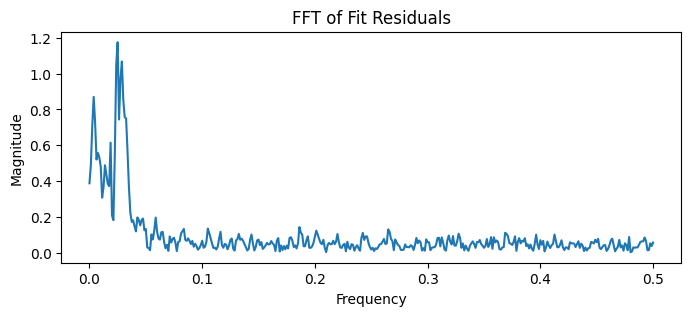

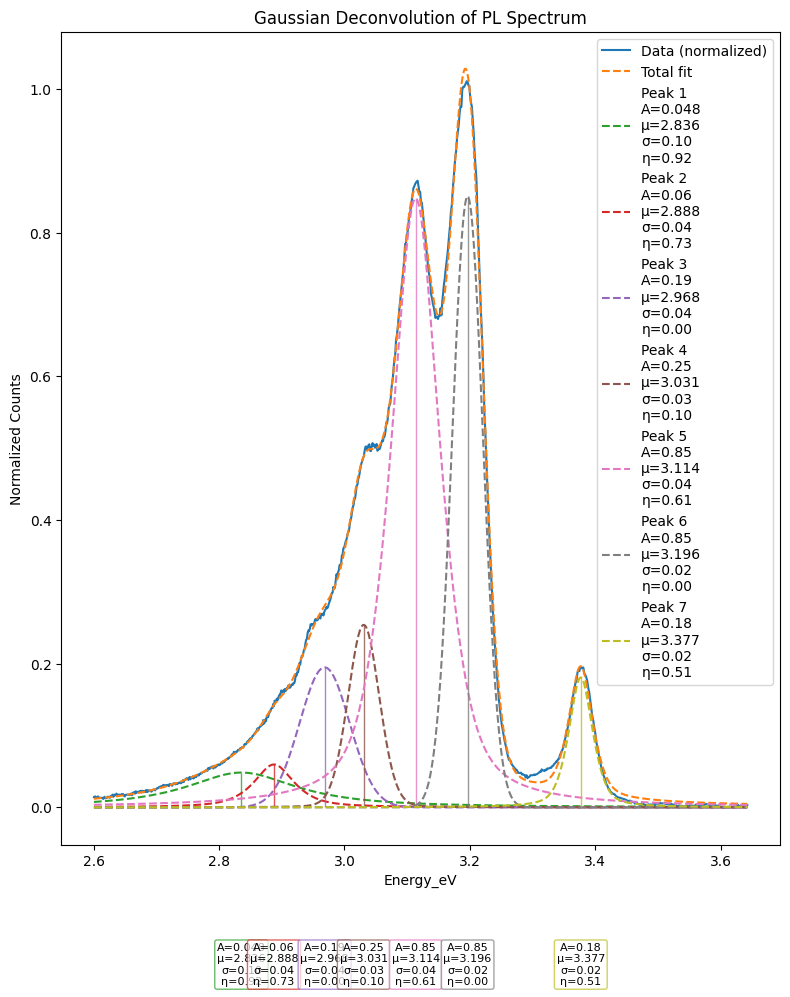

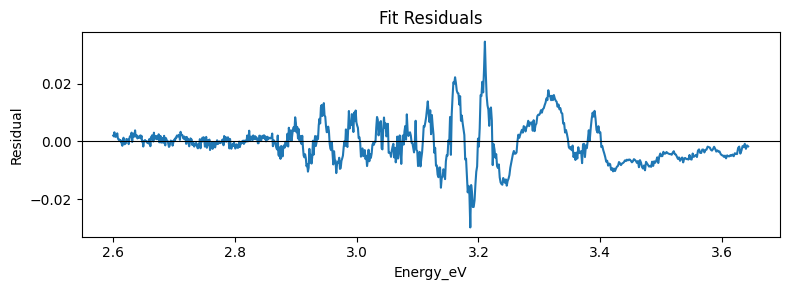

In [ ]:
# Plot individual peaks
def plot_components(ax, x, params, shape):
    """
    Plot individual components plus a vertical line at each peak center,
    with a text label showing A and mu.
    """
    if shape == "gaussian":
        n = len(params) // 3
        for k in range(n):
            A, mu, sig = params[3*k:3*k+3]
            comp = gaussian(x, A, mu, sig)

            # plot component and get its color
            (line,) = ax.plot(x, comp, "--", label=f"Peak {k+1}")
            color = line.get_color()

            # vertical line from 0 to peak height
            peak_height = comp.max()
            ax.vlines(mu, 0, peak_height, color=color, linewidth=1.0, alpha=0.8)

            # text label along the line
            ax.text(
                mu,
                peak_height,  # or 0.5*peak_height if you want it in the middle
                f"A={A:.2g}\nμ={mu:.3f}",
                ha="center",
                va="bottom",
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, ec=color),
            )

    elif shape == "lorentzian":
        n = len(params) // 3
        for k in range(n):
            A, mu, gam = params[3*k:3*k+3]
            comp = lorentzian(x, A, mu, gam)

            (line,) = ax.plot(x, comp, "--", label=f"Peak {k+1}")
            color = line.get_color()

            peak_height = comp.max()
            ax.vlines(mu, 0, peak_height, color=color, linewidth=1.0, alpha=0.8)

            ax.text(
                mu,
                peak_height,
                f"A={A:.2g}\nμ={mu:.3f}",
                ha="center",
                va="bottom",
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, ec=color),
            )

    elif shape == "pvoigt":
        n = len(params) // 4
        for k in range(n):
            A, mu, sig, eta = params[4*k:4*k+4]
            comp = pseudo_voigt(x, A, mu, sig, eta)

            (line,) = ax.plot(x, comp, "--", label=f"Peak {k+1}\nA={A:.2g}\nμ={mu:.3f}\nσ={sig:.2f}\nη={eta:.2f}\n-------")
            color = line.get_color()

            peak_height = comp.max()
            ax.vlines(mu, 0, peak_height, color=color, linewidth=1.0, alpha=0.8)

            ax.text(
                mu,
                -0.25,
                f"A={A:.2g}\nμ={mu:.3f}\nσ={sig:.2f}\nη={eta:.2f}",
                ha="center",
                va="bottom",
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, ec=color),
            )
#%matplotlib widget
plt.figure(figsize=(8, 3))
plt.plot(freqs, np.abs(R), label="FFT of Residuals")
plt.title("FFT of Fit Residuals")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")


plt.figure(figsize=(8, 10))S
plt.plot(x, y, label="Data (normalized)", linewidth=1.5)
plt.plot(x, y_fit, "--", label="Total fit", linewidth=1.5)

plot_components(plt.gca(), x, popt_final, PEAK_SHAPE)

plt.xlabel(X_COLUMN)
plt.ylabel("Normalized Counts")
plt.legend()
plt.title("Gaussian Deconvolution of PL Spectrum")
plt.tight_layout()
plt.savefig("PL_spectrum_fit.png", dpi=300)


plt.figure(figsize=(8, 3))
plt.plot(x, residuals, label="Residuals")
plt.axhline(0, color="k", linewidth=0.8)
plt.xlabel(X_COLUMN)
plt.ylabel("Residual")
plt.title("Fit Residuals")
plt.tight_layout()
plt.savefig("PL_spectrum_residuals.png", dpi=300)
plt.show()